<a href="https://colab.research.google.com/github/caiobaptistaa/Econometria-4_PUC-Rio/blob/main/Trabalho_1_Quest_2_AR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Trabalho 1 - (Questão 2) <h1>

<h2> A) Autoregressive Model <h2>

In [ ]:
import pandas as pd
import numpy as np
import pmdarima
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
pd.pandas.set_option('display.max_columns', None)

from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pmdarima.arima import auto_arima

def check_stationarity(series):

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/Trabalho-1/2021-12.csv', sep= ",", low_memory= False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,IPMAT,IPDMAT,IPNMAT,IPMANSICS,IPB51222S,IPFUELS,CUMFNS,HWI,HWIURATIO,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USTPU,USWTRADE,USTRADE,USFIRE,USGOVT,CES0600000007,AWOTMAN,AWHMAN,HOUST,HOUSTNE,HOUSTMW,HOUSTS,HOUSTW,PERMIT,PERMITNE,PERMITMW,PERMITS,PERMITW,ACOGNO,AMDMNOx,ANDENOx,AMDMUOx,BUSINVx,ISRATIOx,M1SL,M2SL,M2REAL,BOGMBASE,TOTRESNS,NONBORRES,BUSLOANS,REALLN,NONREVSL,CONSPI,S&P 500,S&P: indust,S&P div yield,S&P PE ratio,FEDFUNDS,CP3Mx,TB3MS,TB6MS,GS1,GS5,GS10,AAA,BAA,COMPAPFFx,TB3SMFFM,TB6SMFFM,T1YFFM,T5YFFM,T10YFFM,AAAFFM,BAAFFM,TWEXAFEGSMTHx,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,WPSFD49207,WPSFD49502,WPSID61,WPSID62,OILPRICEx,PPICMM,CPIAUCSL,CPIAPPSL,CPITRNSL,CPIMEDSL,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
0,Transform:,5.000,5.0,5.000,5.0000,5.00000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,2.0000,2.0,2.000000,5,5,2.0,2.0,5,5,5,5,5,5,5,5,5.0,5,5,5,5,5,5,5.0,5.0,5,5,1.0,2.0,1.0,4,4,4,4,4,4.0,4.0,4.0,4.0,4.0,5.0,5.00000,5.0,5.00000,5.00000,2.000000,6.0,6.0,5.0,6,6.0,7,6.0000,6.0000,6.00000,2.000000,5.00,5.00,2.000000,5.000000,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,5.0,5.0000,5.0000,5.0000,5.0000,6.0,6.0,6.0,6.0,6.00,6.0,6.00,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.000,6.000,6.000,6.000,6.00,6.00,6.00,2.0,6.0,6.0,6.0000,1.0
1,1/1/1959,2442.158,2293.2,17.272,292266.4261,18235.77392,22.0733,23.4027,22.2858,31.5688,18.6601,38.1454,8.1760,20.2407,12.2794,30.6469,20.9189,19.9060,34.7139,80.1973,1357.0,0.333579,67936,63868,6.0,16.3,1574,1169,1396,594,802,291078,52478,18796,713.0,2993,14998,8740,6258,33682,10774,2568.7,5350.3,2418,8105,39.8,2.5,40.2,1657,350,452,505,350,NaN,NaN,NaN,NaN,NaN,NaN,14716.48296,NaN,42620.34624,84889.55898,1.560000,138.9,286.6,987.9,50500,18.9,18300,35.2130,24.9242,48.96116,0.124965,55.62,59.30,3.158342,18.445741,2.48,3.30,2.82,3.09,3.36,4.01,4.02,4.12,4.87,0.82,0.34,0.61,0.88,1.53,1.54,1.64,2.39,NaN,4.3122,359.8417,2.8065,0.9671,33.1,33.4,30.6,31.6,3.00,32.5,29.01,44.8,29.3,21.1,33.3,38.1,22.9,28.9,30.7,29.6,16.042,56.918,17.791,11.326,2.13,2.45,2.04,NaN,6476.0,12298.0,84.2043,NaN
2,2/1/1959,2451.778,2301.5,17.452,294424.7425,18369.56308,22.5056,23.7185,22.4788,31.8004,18.7580,38.5100,8.2854,20.8817,12.8450,31.1834,21.3034,19.8518,34.2411,81.4428,1421.0,0.358386,67649,63684,5.9,15.5,1554,1164,1277,545,732,282958,52688,18890,704.2,2980,15115,8839,6276,33798,10816,2575.4,5381.3,2420,8116,39.7,2.6,40.3,1667,346,469,508,344,NaN,NaN,NaN,NaN,NaN,NaN,15400.24873,NaN,43677.15151,85181.81131,1.539338,139.4,287.7,992.1,49800,18.6,18100,35.2201,25.2270,49.51371,0.125765,54.77,58.33,3.219518,18.418119,2.43,3.26,2.70,3.13,3.54,3.96,3.96,4.14,4.89,0.83,0.27,0.70,1.11,1.53,1.53,1.71,2.46,NaN,4.3133,359.8417,2.8093,0.9748,33.2,33.4,30.7,31.4,3.00,32.5,29.00,44.7,29.4,21.2,33.3,38.1,23.0,28.9,30.7,29.6,16.057,56.951,17.798,11.343,2.14,2.46,2.05,NaN,6476.0,12298.0,83.5280,NaN
3,3/1/1959,2467.594,2318.5,17.617,293418.6704,18523.05762,22.8298,23.8621,22.5892,31.8004,19.1254,38.3277,8.3749,21.4240,13.3511,31.6519,21.6367,19.9873,35.1079,82.4769,1524.0,0.400947,68068,64267,5.6,15.3,1459,1093,1210,530,680,260346,53014,19069,704.1,3013,15259,8965,6294,33945,10873,2584.4,5431.6,2430,8132,40.0,2.8,40.4,1620,330,413,503,374,NaN,NaN,NaN,NaN,NaN,NaN,15745.42348,NaN,44781.64655,85620.18980,1.529007,139.7,289.2,998.3,49700,18.4,17800,35.1304,25.4218,50.00773,0.126123,56.16,59.79,3.151709,18.999351,2.80,3.35,2.80,3.13,3.61,3.99,3.99,4.13,4.85,0.55,0.00,0.33,0.81,1.19,1.19,1.33,2.05,NaN,4.3228,359.8417,2.8127,0.9698,33.2,33.3,30.7,31.5,2.97,32.9,28.97,44.7,29.6,21

In [ ]:
data.shape

(756, 128)

In [ ]:
[col for col in data.columns if data[col].isnull().any()]

['CMRMTSPLx',
 'HWI',
 'HWIURATIO',
 'PERMIT',
 'PERMITNE',
 'PERMITMW',
 'PERMITS',
 'PERMITW',
 'ACOGNO',
 'ANDENOx',
 'BUSINVx',
 'ISRATIOx',
 'NONREVSL',
 'CONSPI',
 'S&P div yield',
 'S&P PE ratio',
 'CP3Mx',
 'COMPAPFFx',
 'TWEXAFEGSMTHx',
 'UMCSENTx',
 'DTCOLNVHFNM',
 'DTCTHFNM',
 'VIXCLSx']

Dropping all columns with NaN values.

In [ ]:
data.dropna(axis= 1, inplace= True)

In [ ]:
data.shape

(756, 105)

In [ ]:
data.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,IPMAT,IPDMAT,IPNMAT,IPMANSICS,IPB51222S,IPFUELS,CUMFNS,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USTPU,USWTRADE,USTRADE,USFIRE,USGOVT,CES0600000007,AWOTMAN,AWHMAN,HOUST,HOUSTNE,HOUSTMW,HOUSTS,HOUSTW,AMDMNOx,AMDMUOx,M1SL,M2SL,M2REAL,BOGMBASE,TOTRESNS,NONBORRES,BUSLOANS,REALLN,S&P 500,S&P: indust,FEDFUNDS,TB3MS,TB6MS,GS1,GS5,GS10,AAA,BAA,TB3SMFFM,TB6SMFFM,T1YFFM,T5YFFM,T10YFFM,AAAFFM,BAAFFM,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,WPSFD49207,WPSFD49502,WPSID61,WPSID62,OILPRICEx,PPICMM,CPIAUCSL,CPIAPPSL,CPITRNSL,CPIMEDSL,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,INVEST
0,Transform:,5.000,5.0,5.000,5.00000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,2.0000,5,5,2.0,2.0,5,5,5,5,5,5,5,5,5.0,5,5,5,5,5,5,5.0,5.0,5,5,1.0,2.0,1.0,4,4,4,4,4,5.00000,5.00000,6.0,6.0,5.0,6,6.0,7,6.0000,6.0000,5.00,5.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,5.0000,5.0000,5.0000,5.0000,6.0,6.0,6.0,6.0,6.00,6.0,6.00,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.000,6.000,6.000,6.000,6.00,6.00,6.00,6.0000
1,1/1/1959,2442.158,2293.2,17.272,18235.77392,22.0733,23.4027,22.2858,31.5688,18.6601,38.1454,8.1760,20.2407,12.2794,30.6469,20.9189,19.9060,34.7139,80.1973,67936,63868,6.0,16.3,1574,1169,1396,594,802,291078,52478,18796,713.0,2993,14998,8740,6258,33682,10774,2568.7,5350.3,2418,8105,39.8,2.5,40.2,1657,350,452,505,350,14716.48296,42620.34624,138.9,286.6,987.9,50500,18.9,18300,35.2130,24.9242,55.62,59.30,2.48,2.82,3.09,3.36,4.01,4.02,4.12,4.87,0.34,0.61,0.88,1.53,1.54,1.64,2.39,4.3122,359.8417,2.8065,0.9671,33.1,33.4,30.6,31.6,3.00,32.5,29.01,44.8,29.3,21.1,33.3,38.1,22.9,28.9,30.7,29.6,16.042,56.918,17.791,11.326,2.13,2.45,2.04,84.2043
2,2/1/1959,2451.778,2301.5,17.452,18369.56308,22.5056,23.7185,22.4788,31.8004,18.7580,38.5100,8.2854,20.8817,12.8450,31.1834,21.3034,19.8518,34.2411,81.4428,67649,63684,5.9,15.5,1554,1164,1277,545,732,282958,52688,18890,704.2,2980,15115,8839,6276,33798,10816,2575.4,5381.3,2420,8116,39.7,2.6,40.3,1667,346,469,508,344,15400.24873,43677.15151,139.4,287.7,992.1,49800,18.6,18100,35.2201,25.2270,54.77,58.33,2.43,2.70,3.13,3.54,3.96,3.96,4.14,4.89,0.27,0.70,1.11,1.53,1.53,1.71,2.46,4.3133,359.8417,2.8093,0.9748,33.2,33.4,30.7,31.4,3.00,32.5,29.00,44.7,29.4,21.2,33.3,38.1,23.0,28.9,30.7,29.6,16.057,56.951,17.798,11.343,2.14,2.46,2.05,83.5280
3,3/1/1959,2467.594,2318.5,17.617,18523.05762,22.8298,23.8621,22.5892,31.8004,19.1254,38.3277,8.3749,21.4240,13.3511,31.6519,21.6367,19.9873,35.1079,82.4769,68068,64267,5.6,15.3,1459,1093,1210,530,680,260346,53014,19069,704.1,3013,15259,8965,6294,33945,10873,2584.4,5431.6,2430,8132,40.0,2.8,40.4,1620,330,413,503,374,15745.42348,44781.64655,139.7,289.2,998.3,49700,18.4,17800,35.1304,25.4218,56.16,59.79,2.80,2.80,3.13,3.61,3.99,3.99,4.13,4.85,0.00,0.33,0.81,1.19,1.19,1.33,2.05,4.3228,359.8417,2.8127,0.9698,33.2,33.3,30.7,31.5,2.97,32.9,28.97,44.7,29.6,21.3,33.2,38.3,23.0,28.9,30.7,29.6,16.068,57.022,17.785,11.363,2.15,2.45,2.07,81.6405
4,4/1/1959,2483.671,2334.9,17.553,18534.46600,23.3161,24.2067,22.9201,32.3021,19.2478,38.9658,8.5937,22.0157,13.7530,32.6322,22.0981,20.0685,34.9503,83.9922,68339,64768,5.2,14.9,1494,934,1039,408,631,246413,53321,19269,705.2,3085,15385,9077,6308,34052,10905,2596.9,5395.4,2439,8142,40.2,2.9,40.5,1590,275,391,536,388,15919.42165,45522.74556,139.7,290.1,1001.0,50100,18.7,18000,35.5581,25.7261,57.10,60.92,2.96,2.95,3.27,3.72,4.12,4.12,4.23,4.86,-0.01,0.31,0.76,1.16,1.16,1.27,1.90,4.3226,359.8417,2.8165,0.9636,33.2,33.4,30.7,31.7,2.97,32.7,28.98,44.8,29.7,21.3,33.2,38.3,23.1,29.0,30.7,29.6,16.100,57.080,17.796,11.403,2.16,2.47,2.08,81.8099


Creating CPI series and add date time

In [ ]:
CPI = data[["sasdate", "CPIAUCSL"]].copy()

In [ ]:
data = data.drop(columns = "CPIAUCSL")

In [ ]:
CPI.head()

,sasdate,CPIAUCSL
0,Transform:,6.00
1,1/1/1959,29.01
2,2/1/1959,29.00
3,3/1/1959,28.97
4,4/1/1959,28.98


In [ ]:
CPI = CPI.drop([0])

In [ ]:
CPI.head()

,sasdate,CPIAUCSL
1,1/1/1959,29.01
2,2/1/1959,29.00
3,3/1/1959,28.97
4,4/1/1959,28.98
5,5/1/1959,29.04


In [ ]:
CPI["sasdate"] = CPI["sasdate"].str.replace("/1/", "-")
CPI.head()

,sasdate,CPIAUCSL
1,1-1959,29.01
2,2-1959,29.00
3,3-1959,28.97
4,4-1959,28.98
5,5-1959,29.04


In [ ]:
CPI["sasdate"] = pd.to_datetime(CPI["sasdate"], format = "%m-%Y")

In [ ]:
CPI.head()

,sasdate,CPIAUCSL
1,1959-01-01,29.01
2,1959-02-01,29.00
3,1959-03-01,28.97
4,1959-04-01,28.98
5,1959-05-01,29.04


Transformation of CPI: ΔCPIt/CPIt

In [ ]:
CPI["CPIAUCSL"] = (CPI["CPIAUCSL"] - CPI["CPIAUCSL"].shift(1))/CPI["CPIAUCSL"]
CPI.head()

,sasdate,CPIAUCSL
1,1959-01-01,NaN
2,1959-02-01,-0.000345
3,1959-03-01,-0.001036
4,1959-04-01,0.000345
5,1959-05-01,0.002066


In [ ]:
CPI = CPI.drop([1])
CPI.head()

,sasdate,CPIAUCSL
2,1959-02-01,-0.000345
3,1959-03-01,-0.001036
4,1959-04-01,0.000345
5,1959-05-01,0.002066
6,1959-06-01,0.002405


Manipulation and transformations of features

In [ ]:
def tcode(data):
  for i in data.columns:
    if data.loc[0, i] == 2.0:
      data[i] = data[i] - data[i].shift(1)
    if data.loc[0, i] == 3.0:
      data[i] = (data[i] - data[i].shift(1))**2
    if data.loc[0, i] == 4.0:
      data[i] = np.log(data[i])
    if data.loc[0, i] == 5.0:
      data[i] = np.log(data[i]) - np.log(data[i].shift(1))
    if data.loc[0, i] == 6.0:
      data[i] = (np.log(data[i]) - np.log(data[i].shift(1)))**2
    if data.loc[0, i] == 7.0:
      data[i] = (data[i]/(data[i].shift(1) - 1)) - (data[i].shift(1)/(data[i].shift(2) - 1))
  return data

In [ ]:
data.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,IPMAT,IPDMAT,IPNMAT,IPMANSICS,IPB51222S,IPFUELS,CUMFNS,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USTPU,USWTRADE,USTRADE,USFIRE,USGOVT,CES0600000007,AWOTMAN,AWHMAN,HOUST,HOUSTNE,HOUSTMW,HOUSTS,HOUSTW,AMDMNOx,AMDMUOx,M1SL,M2SL,M2REAL,BOGMBASE,TOTRESNS,NONBORRES,BUSLOANS,REALLN,S&P 500,S&P: indust,FEDFUNDS,TB3MS,TB6MS,GS1,GS5,GS10,AAA,BAA,TB3SMFFM,TB6SMFFM,T1YFFM,T5YFFM,T10YFFM,AAAFFM,BAAFFM,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,WPSFD49207,WPSFD49502,WPSID61,WPSID62,OILPRICEx,PPICMM,CPIAPPSL,CPITRNSL,CPIMEDSL,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,INVEST
0,Transform:,5.000,5.0,5.000,5.00000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,2.0000,5,5,2.0,2.0,5,5,5,5,5,5,5,5,5.0,5,5,5,5,5,5,5.0,5.0,5,5,1.0,2.0,1.0,4,4,4,4,4,5.00000,5.00000,6.0,6.0,5.0,6,6.0,7,6.0000,6.0000,5.00,5.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,5.0000,5.0000,5.0000,5.0000,6.0,6.0,6.0,6.0,6.00,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.000,6.000,6.000,6.000,6.00,6.00,6.00,6.0000
1,1/1/1959,2442.158,2293.2,17.272,18235.77392,22.0733,23.4027,22.2858,31.5688,18.6601,38.1454,8.1760,20.2407,12.2794,30.6469,20.9189,19.9060,34.7139,80.1973,67936,63868,6.0,16.3,1574,1169,1396,594,802,291078,52478,18796,713.0,2993,14998,8740,6258,33682,10774,2568.7,5350.3,2418,8105,39.8,2.5,40.2,1657,350,452,505,350,14716.48296,42620.34624,138.9,286.6,987.9,50500,18.9,18300,35.2130,24.9242,55.62,59.30,2.48,2.82,3.09,3.36,4.01,4.02,4.12,4.87,0.34,0.61,0.88,1.53,1.54,1.64,2.39,4.3122,359.8417,2.8065,0.9671,33.1,33.4,30.6,31.6,3.00,32.5,44.8,29.3,21.1,33.3,38.1,22.9,28.9,30.7,29.6,16.042,56.918,17.791,11.326,2.13,2.45,2.04,84.2043
2,2/1/1959,2451.778,2301.5,17.452,18369.56308,22.5056,23.7185,22.4788,31.8004,18.7580,38.5100,8.2854,20.8817,12.8450,31.1834,21.3034,19.8518,34.2411,81.4428,67649,63684,5.9,15.5,1554,1164,1277,545,732,282958,52688,18890,704.2,2980,15115,8839,6276,33798,10816,2575.4,5381.3,2420,8116,39.7,2.6,40.3,1667,346,469,508,344,15400.24873,43677.15151,139.4,287.7,992.1,49800,18.6,18100,35.2201,25.2270,54.77,58.33,2.43,2.70,3.13,3.54,3.96,3.96,4.14,4.89,0.27,0.70,1.11,1.53,1.53,1.71,2.46,4.3133,359.8417,2.8093,0.9748,33.2,33.4,30.7,31.4,3.00,32.5,44.7,29.4,21.2,33.3,38.1,23.0,28.9,30.7,29.6,16.057,56.951,17.798,11.343,2.14,2.46,2.05,83.5280
3,3/1/1959,2467.594,2318.5,17.617,18523.05762,22.8298,23.8621,22.5892,31.8004,19.1254,38.3277,8.3749,21.4240,13.3511,31.6519,21.6367,19.9873,35.1079,82.4769,68068,64267,5.6,15.3,1459,1093,1210,530,680,260346,53014,19069,704.1,3013,15259,8965,6294,33945,10873,2584.4,5431.6,2430,8132,40.0,2.8,40.4,1620,330,413,503,374,15745.42348,44781.64655,139.7,289.2,998.3,49700,18.4,17800,35.1304,25.4218,56.16,59.79,2.80,2.80,3.13,3.61,3.99,3.99,4.13,4.85,0.00,0.33,0.81,1.19,1.19,1.33,2.05,4.3228,359.8417,2.8127,0.9698,33.2,33.3,30.7,31.5,2.97,32.9,44.7,29.6,21.3,33.2,38.3,23.0,28.9,30.7,29.6,16.068,57.022,17.785,11.363,2.15,2.45,2.07,81.6405
4,4/1/1959,2483.671,2334.9,17.553,18534.46600,23.3161,24.2067,22.9201,32.3021,19.2478,38.9658,8.5937,22.0157,13.7530,32.6322,22.0981,20.0685,34.9503,83.9922,68339,64768,5.2,14.9,1494,934,1039,408,631,246413,53321,19269,705.2,3085,15385,9077,6308,34052,10905,2596.9,5395.4,2439,8142,40.2,2.9,40.5,1590,275,391,536,388,15919.42165,45522.74556,139.7,290.1,1001.0,50100,18.7,18000,35.5581,25.7261,57.10,60.92,2.96,2.95,3.27,3.72,4.12,4.12,4.23,4.86,-0.01,0.31,0.76,1.16,1.16,1.27,1.90,4.3226,359.8417,2.8165,0.9636,33.2,33.4,30.7,31.7,2.97,32.7,44.8,29.7,21.3,33.2,38.3,23.1,29.0,30.7,29.6,16.100,57.080,17.796,11.403,2.16,2.47,2.08,81.8099


In [ ]:
data = tcode(data)

In [ ]:
data.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,IPMAT,IPDMAT,IPNMAT,IPMANSICS,IPB51222S,IPFUELS,CUMFNS,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USTPU,USWTRADE,USTRADE,USFIRE,USGOVT,CES0600000007,AWOTMAN,AWHMAN,HOUST,HOUSTNE,HOUSTMW,HOUSTS,HOUSTW,AMDMNOx,AMDMUOx,M1SL,M2SL,M2REAL,BOGMBASE,TOTRESNS,NONBORRES,BUSLOANS,REALLN,S&P 500,S&P: indust,FEDFUNDS,TB3MS,TB6MS,GS1,GS5,GS10,AAA,BAA,TB3SMFFM,TB6SMFFM,T1YFFM,T5YFFM,T10YFFM,AAAFFM,BAAFFM,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,WPSFD49207,WPSFD49502,WPSID61,WPSID62,OILPRICEx,PPICMM,CPIAPPSL,CPITRNSL,CPIMEDSL,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,INVEST
0,Transform:,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.386294,1.386294,1.386294,1.386294,1.386294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,1.00,1.00,1.00,1.00,1.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1/1/1959,6.191199,6.128266,1.239649,8.201703,1.484931,1.543413,1.494512,1.842731,1.316950,2.031967,0.491765,1.398258,0.898485,1.813094,1.431215,1.381583,1.937702,78.1973,9.516883,9.455136,4.0,14.3,5.751938,5.454466,5.631928,4.777441,5.077671,10.971909,9.258711,8.231961,4.960044,6.394594,8.006234,7.466228,7.132178,8.815281,7.675453,6.241717,6.975470,6.181258,7.390799,39.8,0.5,40.2,7.412764,5.857933,6.113682,6.224558,5.857933,7.987286,9.050649,9.872131,14.948493,5.286144,81.684886,1.316532,NaN,3.131682e+00,2.028003,2.409105,2.473171,0.48,0.82,1.09,1.36,2.01,2.02,2.12,2.87,0.34,0.61,0.88,1.53,1.54,1.64,2.39,-0.147990,4.276226,-0.577500,-1.642891,2.916491,2.947390,2.654425,2.760242,0.480453,2.854345,4.041904,2.514851,1.581340,2.937103,3.416785,1.793932,2.471442,2.665067,2.547264,9.671755e-01,5.061835e+00,1.181424e+00,0.403659,1.072545,0.802227,1.163830,6.977451
2,2/1/1959,0.003931,0.003613,0.010368,0.007310,0.019395,0.013404,0.008623,0.007310,0.005233,0.009513,0.013292,0.031178,0.045032,0.017354,0.018214,-0.002727,-0.013714,1.2455,-0.004234,-0.002885,-0.1,-0.8,-0.012788,-0.004286,-0.089097,-0.086094,-0.091328,-0.028293,0.003994,0.004989,-0.012419,-0.004353,0.007771,0.011264,0.002872,0.003438,0.003891,0.002605,0.005777,0.000827,0.001356,39.7,0.1,40.3,7.418781,5.846439,6.150603,6.230481,5.840642,0.045416,0.024493,0.000013,0.000015,0.004242,0.000195,0.000256,-3049.010875,4.064649e-08,0.000146,-0.015400,-0.016493,-0.05,-0.12,0.04,0.18,-0.05,-0.06,0.02,0.02,0.27,0.70,1.11,1.53,1.53,1.71,2.46,0.000255,0.000000,0.000997,0.007930,0.000009,0.000000,0.000011,0.000040,0.000000,0.000000,0.000005,0.000012,0.000022,0.000000,0.000000,0.000019,0.000000,0.000000,0.000000,8.734933e-07,3.359517e-07,1.547478e-07,0.000002,0.000022,0.000017,0.000024,0.000065
3,3/1/1959,0.006430,0.007359,0.009410,0.008321,0.014303,0.006036,0.004899,0.000000,0.019397,-0.004745,0.010744,0.025639,0.038644,0.014912,0.015524,0.006802,0.024999,1.0341,0.006175,0.009113,-0.3,-0.2,-0.063081,-0.062936,-0.053893,-0.027909,-0.073688,-0.083287,0.006168,0.009431,-0.000142,0.011013,0.009482,0.014154,0.002864,0.004340,0.005256,0.003489,0.009304,0.004124,0.001969,40.0,0.2,40.4,7.390181,5.799093,6.023448,6.220590,5.924256,0.022166,0.024973,0.000005,0.000027,0.006230,0.000004,0.000117,-0.005645,6.502958e-06,0.000059,0.025062,0.024722,0.37,0.10,0.00,0.07,0.03,0.03,-0.01,-0.04,0.00,0.33,0.81,1.19,1.19,1.33,2.05,0.002200,0.000000,0.001210,-0.005142,0.000000,0.000009,0.000000,0.000010,0.000101,0.000150,0.000000,0.000046,0.000022,0.000009,0.000027,0.000000,0.000000,0.000000,0.000000,4.689852e-07,1.552290e-06,5.339021e-07,0.000003,0.000022,0.000017,0.000094,0.000522
4,

In [ ]:
data = data.drop([0, 1])

In [ ]:
data["sasdate"] = data["sasdate"].str.replace("/1/", "-")
data["sasdate"] = pd.to_datetime(data["sasdate"], format = "%m-%Y")
data.head()

,sasdate,RPI,W875RX1,DPCERA3M086SBEA,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,IPMAT,IPDMAT,IPNMAT,IPMANSICS,IPB51222S,IPFUELS,CUMFNS,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,USTPU,USWTRADE,USTRADE,USFIRE,USGOVT,CES0600000007,AWOTMAN,AWHMAN,HOUST,HOUSTNE,HOUSTMW,HOUSTS,HOUSTW,AMDMNOx,AMDMUOx,M1SL,M2SL,M2REAL,BOGMBASE,TOTRESNS,NONBORRES,BUSLOANS,REALLN,S&P 500,S&P: indust,FEDFUNDS,TB3MS,TB6MS,GS1,GS5,GS10,AAA,BAA,TB3SMFFM,TB6SMFFM,T1YFFM,T5YFFM,T10YFFM,AAAFFM,BAAFFM,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,WPSFD49207,WPSFD49502,WPSID61,WPSID62,OILPRICEx,PPICMM,CPIAPPSL,CPITRNSL,CPIMEDSL,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,INVEST
2,1959-02-01,0.003931,0.003613,0.010368,0.007310,0.019395,0.013404,0.008623,0.007310,0.005233,0.009513,0.013292,0.031178,0.045032,0.017354,0.018214,-0.002727,-0.013714,1.2455,-0.004234,-0.002885,-0.1,-0.8,-0.012788,-0.004286,-0.089097,-0.086094,-0.091328,-0.028293,0.003994,0.004989,-0.012419,-0.004353,0.007771,0.011264,0.002872,0.003438,0.003891,0.002605,0.005777,0.000827,0.001356,39.7,0.1,40.3,7.418781,5.846439,6.150603,6.230481,5.840642,0.045416,0.024493,0.000013,0.000015,0.004242,0.000195,0.000256,-3049.010875,4.064649e-08,0.000146,-0.015400,-0.016493,-0.05,-0.12,0.04,0.18,-0.05,-0.06,0.02,0.02,0.27,0.70,1.11,1.53,1.53,1.71,2.46,0.000255,0.0,0.000997,0.007930,0.000009,0.000000,0.000011,0.000040,0.000000,0.000000,0.000005,0.000012,0.000022,0.000000,0.000000,0.000019,0.000000,0.000000,0.000000,8.734933e-07,3.359517e-07,1.547478e-07,0.000002,0.000022,0.000017,0.000024,0.000065
3,1959-03-01,0.006430,0.007359,0.009410,0.008321,0.014303,0.006036,0.004899,0.000000,0.019397,-0.004745,0.010744,0.025639,0.038644,0.014912,0.015524,0.006802,0.024999,1.0341,0.006175,0.009113,-0.3,-0.2,-0.063081,-0.062936,-0.053893,-0.027909,-0.073688,-0.083287,0.006168,0.009431,-0.000142,0.011013,0.009482,0.014154,0.002864,0.004340,0.005256,0.003489,0.009304,0.004124,0.001969,40.0,0.2,40.4,7.390181,5.799093,6.023448,6.220590,5.924256,0.022166,0.024973,0.000005,0.000027,0.006230,0.000004,0.000117,-0.005645,6.502958e-06,0.000059,0.025062,0.024722,0.37,0.10,0.00,0.07,0.03,0.03,-0.01,-0.04,0.00,0.33,0.81,1.19,1.19,1.33,2.05,0.002200,0.0,0.001210,-0.005142,0.000000,0.000009,0.000000,0.000010,0.000101,0.000150,0.000000,0.000046,0.000022,0.000009,0.000027,0.000000,0.000000,0.000000,0.000000,4.689852e-07,1.552290e-06,5.339021e-07,0.000003,0.000022,0.000017,0.000094,0.000522
4,1959-04-01,0.006494,0.007049,-0.003639,0.000616,0.021077,0.014338,0.014542,0.015653,0.006379,0.016511,0.025790,0.027244,0.029658,0.030501,0.021101,0.004054,-0.004499,1.5153,0.003973,0.007765,-0.4,-0.4,0.023706,-0.157205,-0.152362,-0.261610,-0.074787,-0.055003,0.005774,0.010434,0.001561,0.023615,0.008224,0.012416,0.002222,0.003147,0.002939,0.004825,-0.006687,0.003697,0.001229,40.2,0.1,40.5,7.371489,5.616771,5.968708,6.284134,5.961005,0.010990,0.016414,0.000000,0.000010,0.002701,0.000064,0.000262,0.027813,1.464372e-04,0.000142,0.016599,0.018723,0.16,0.15,0.14,0.11,0.13,0.13,0.10,0.01,-0.01,0.31,0.76,1.16,1.16,1.27,1.90,-0.000046,0.0,0.001350,-0.006414,0.000000,0.000009,0.000000,0.000040,0.000000,0.000037,0.000005,0.000011,0.000000,0.000000,0.000000,0.000019,0.000012,0.000000,0.000000,3.958331e-06,1.033545e-06,3.823042e-07,0.000012,0.000022,0.000066,0.000023,0.000004
5,1959-05-01,0.005763,0.006616,0.012005,0.007803,0.014950,0.008269,0.009583,0.004768,0.020151,0.000000,0.031893,0.025433,0.034046,0.008942,0.013828,0.014735,-0.019350,0.9237,-0.002359,-0.001066,-0.1,-0.2,-0.010091,0.073266,-0.073886,-0.045120,-0.092936,0.002185,0.004286,0.005641,0.006784,0.000648,0.006608,0.009102,0.003008,0.003518,0.004027,0.004035,0.011224,0.003275,0.001350,40.3,0.0,40.7,7.311886,5.560682,5.872118,6.188264,5.981414,-0.043038,-0.003043,

In [ ]:
data.to_csv("/content/drive/MyDrive/Trabalho-1/data.csv", index = False)

checking stationarity of the series

In [ ]:
CPI.head()

,sasdate,CPIAUCSL
2,1959-02-01,-0.000345
3,1959-03-01,-0.001036
4,1959-04-01,0.000345
5,1959-05-01,0.002066
6,1959-06-01,0.002405


In [ ]:
check_stationarity(CPI["CPIAUCSL"])

ADF Statistic: -2.787234
p-value: 0.060121
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Non-stationary


In [ ]:
CPI["CPIAUCSL_diff"] = CPI['CPIAUCSL'].diff()
CPI = CPI.dropna()
CPI.head()

,sasdate,CPIAUCSL,CPIAUCSL_diff
3,1959-03-01,-0.001036,-0.000691
4,1959-04-01,0.000345,0.001381
5,1959-05-01,0.002066,0.001721
6,1959-06-01,0.002405,0.000339
7,1959-07-01,0.001372,-0.001032


In [ ]:
check_stationarity(CPI["CPIAUCSL_diff"])

ADF Statistic: -11.270179
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Stationary


In [ ]:
CPI.head()

,sasdate,CPIAUCSL,CPIAUCSL_diff
3,1959-03-01,-0.001036,-0.000691
4,1959-04-01,0.000345,0.001381
5,1959-05-01,0.002066,0.001721
6,1959-06-01,0.002405,0.000339
7,1959-07-01,0.001372,-0.001032


In [ ]:
CPI.to_csv("/content/drive/MyDrive/Trabalho-1/CPI.csv", index = False)

In [ ]:
CPI = CPI.reset_index(drop= True)

In [ ]:
CPI_diff = CPI.copy()

In [ ]:
CPI_diff.head()

,sasdate,CPIAUCSL,CPIAUCSL_diff
0,1959-03-01,-0.001036,-0.000691
1,1959-04-01,0.000345,0.001381
2,1959-05-01,0.002066,0.001721
3,1959-06-01,0.002405,0.000339
4,1959-07-01,0.001372,-0.001032


In [ ]:
date = CPI_diff["sasdate"]
date = pd.DataFrame(date)
date = date.reset_index(drop = True)
date

,sasdate
0,1959-03-01
1,1959-04-01
2,1959-05-01
3,1959-06-01
4,1959-07-01
...,...
748,2021-07-01
749,2021-08-01
750,2021-09-01
751,2021-10-01


In [ ]:
CPI_diff = CPI_diff.drop(columns = ["sasdate", "CPIAUCSL"])

In [ ]:
CPI_st = StandardScaler().fit_transform(CPI_diff)

In [ ]:
CPI_st = pd.DataFrame(CPI_st, columns = CPI_diff.columns)
CPI_st.head()

,CPIAUCSL_diff
0,-0.261529
1,0.510751
2,0.637677
3,0.122229
4,-0.388940


In [ ]:
CPI_diff_st = date.merge(CPI_st, left_index = True, right_index = True, how = "left")

In [ ]:
CPI_diff_st.index = pd.DatetimeIndex(CPI_diff_st["sasdate"])
CPI_diff_st = CPI_diff_st.drop(columns = ["sasdate"])

<h3> a) Autoregressive Model <h3>

In [ ]:
 from matplotlib import pyplot as plt

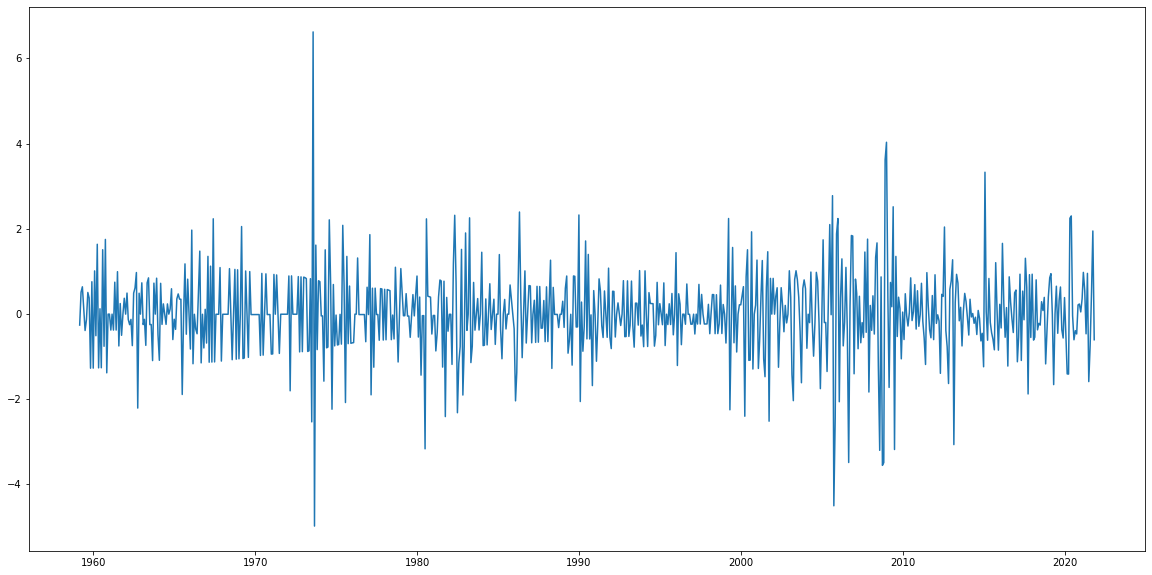

In [ ]:
ts_CPI_diff = pd.Series(CPI_diff_st["CPIAUCSL_diff"].values, index = CPI_diff_st.index)
plt.figure(figsize= (20, 10))
plt.plot(ts_CPI_diff)

Check ACF and PACF

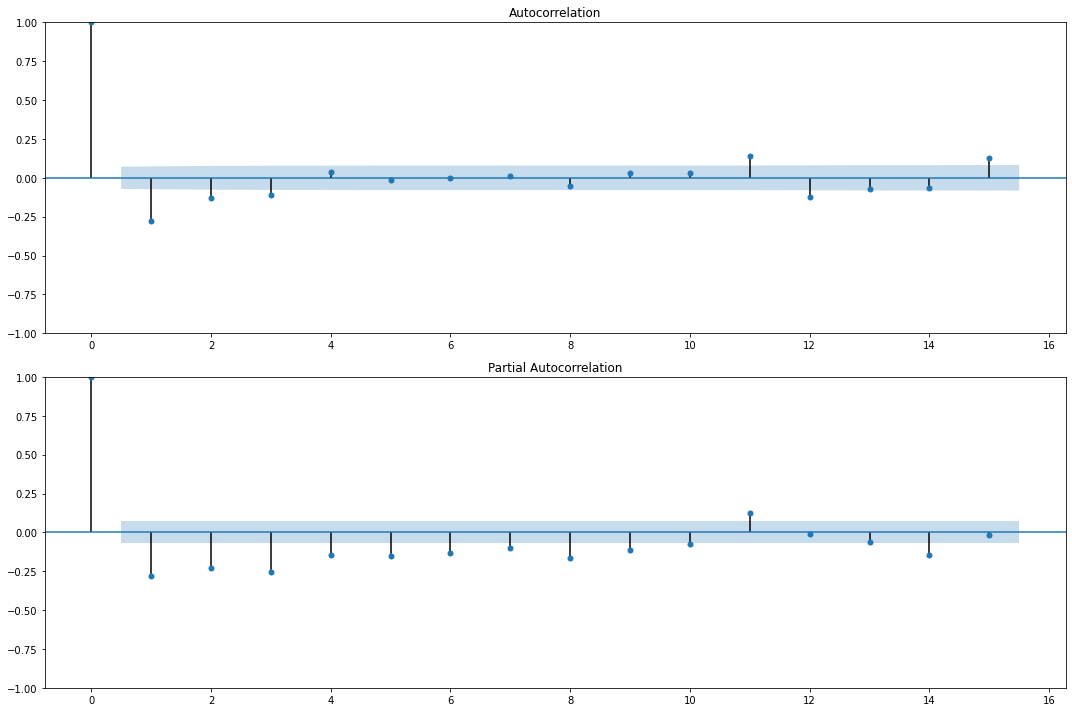

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
plot_acf(ts_CPI_diff,lags=15, ax=ax[0])
plot_pacf(ts_CPI_diff,lags=15, ax=ax[1], method='ols')
plt.tight_layout()
plt.show()

Check the information criterions AIC and BIC

In [ ]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

In [ ]:
CPI_diff_st.shape

(753, 1)

In [ ]:
CPI_diff_st.head()

,CPIAUCSL_diff
sasdate,
1959-03-01,-0.261529
1959-04-01,0.510751
1959-05-01,0.637677
1959-06-01,0.122229
1959-07-01,-0.388940


Below we can see the Sliding Window Forecast algorithm. The windows are fixed at 492 observations for training and a one-step-ahead prediction 492 + 1. How can we select the best model? Here we select the model by order of AR, and choose the order that generates the smallest BIC. Then, we estimate 12 Autoregressive Models for each estimation window and select the best order, later we estimate the model with this order.
The forecast period is from March 2000 to November 2021.

*   Total Data   : x x x x x x x x x x x x
*   1 estimation : - x x x x x x o - - - - 
*   2 estimation : - - x x x x x x o - - -
*   3 estimation : - - - x x x x x x o - -
*   4 estimation : - - - - x x x x x x o -
*   5 estimation : - - - - - x x x x x x o


Where the x's are the sliding window and the "o" are the predicted observation. (representative number of estimation).

In [ ]:
X = CPI_diff_st["CPIAUCSL_diff"].values
train, test = X[0:492], X[492:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	history = history[-492:]
	model = auto_arima(history, start_p=1, start_q=0,
                      test='adf',
                      max_p=12, max_q=0,
                      m=0, 
                      information_criterion='bic',            
                      d=1,          
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
	model_fit = model.fit(history)
	output = model_fit.predict(n_periods= 1)
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f, window_size=%f' % (yhat, obs, (len(history)-1)))
mse = mean_squared_error(test, predictions)
rmse = sqrt(mean_squared_error(test, predictions))
mae = mean_absolute_error(test, predictions)
print('Test MSE: %.5f' % mse, 'Test RMSE: %.5f' % rmse, 'Test MAE: %.5f' % mae)

Estimated results have been deleted for better viewing.

In [ ]:
print('Test MSE: %.5f' % mse, 'Test RMSE: %.5f' % rmse, 'Test MAE: %.5f' % mae)

Test MSE: 1.39414 Test RMSE: 1.18074 Test MAE: 0.82937


In [ ]:
len(predictions), len(test), len(X)

(261, 261, 753)

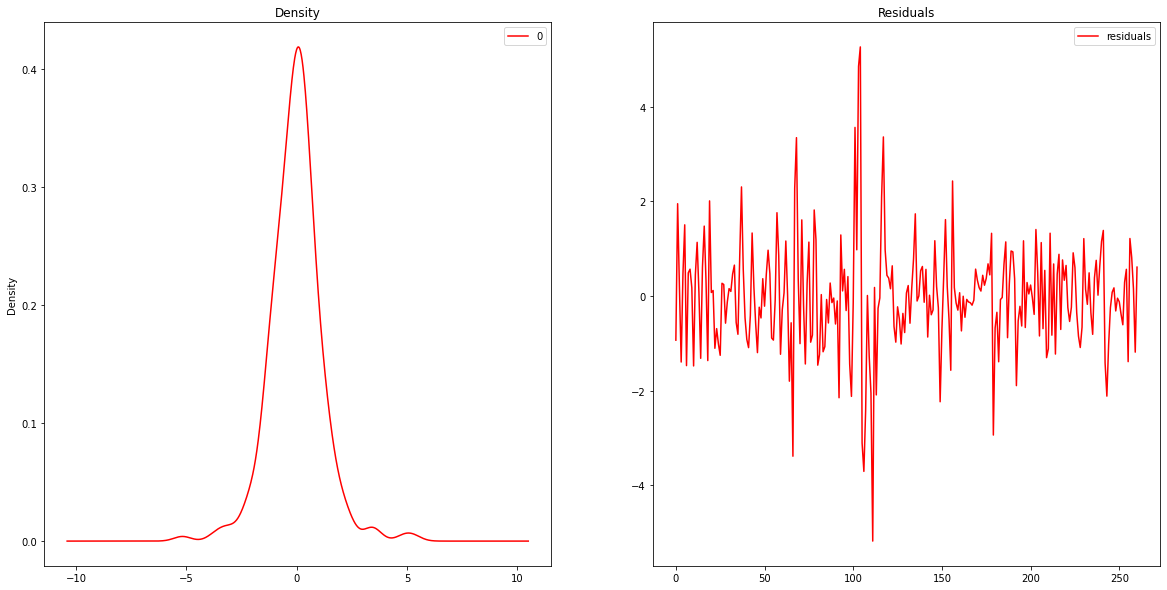

In [ ]:
pred_df = pd.DataFrame(predictions)
observed_df = pd.DataFrame(test)
residuals = pd.DataFrame(pred_df - observed_df)
fig, ax = plt.subplots(1,2, figsize = (20, 10))
residuals.plot(kind='kde', title='Density', ax=ax[0], color = "red")
residuals.plot(title="Residuals", ax=ax[1], color = "red")
plt.legend(["residuals"])
plt.show()

In [ ]:
date = date[492: len(date)]
date = date.reset_index(drop= True)
date.head()

,sasdate
0,2000-03-01
1,2000-04-01
2,2000-05-01
3,2000-06-01
4,2000-07-01


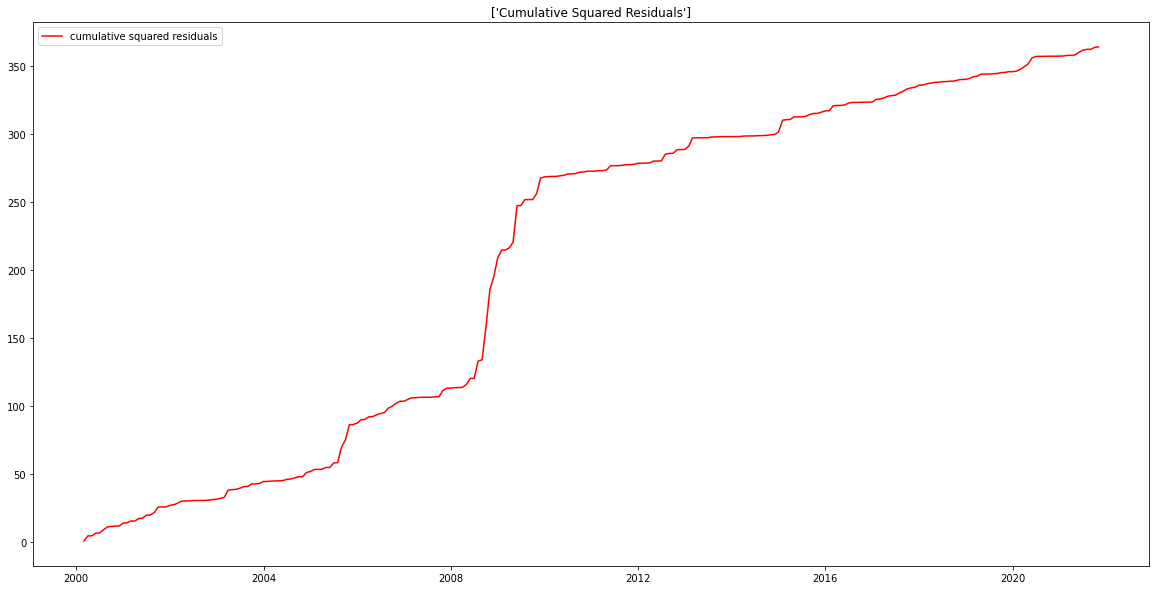

In [ ]:
squared_residuals = residuals**2
cumsum_sqd_residuals = np.cumsum(squared_residuals)
cumsum_sqd_residuals_date = date.merge(cumsum_sqd_residuals, left_index = True, right_index = True, how = "left")
cumsum_sqd_residuals_date.index = pd.DatetimeIndex(cumsum_sqd_residuals_date["sasdate"])
cumsum_sqd_residuals_date = cumsum_sqd_residuals_date.drop(columns = ["sasdate"])

plt.figure(figsize= (20, 10))

plt.plot(cumsum_sqd_residuals_date, color = "red")
plt.title(["Cumulative Squared Residuals"])
plt.legend(["cumulative squared residuals"], loc = "upper left")

In [ ]:
date.head()

,sasdate
0,2000-03-01
1,2000-04-01
2,2000-05-01
3,2000-06-01
4,2000-07-01


In [ ]:
dff = date.merge(pred_df, left_index = True, right_index = True, how = "left")
df = dff.merge(observed_df, left_index = True, right_index = True, how = "left")
df.head()

,sasdate,0_x,0_y
0,2000-03-01,-0.291454,0.641128
1,2000-04-01,-0.449681,-2.402509
2,2000-05-01,1.076792,0.867504
3,2000-06-01,0.113234,1.507815
4,2000-07-01,-0.619068,-1.089710


In [ ]:
df.index = pd.DatetimeIndex(df["sasdate"])
df = df.drop(columns = ["sasdate"])

In [ ]:
df = df.rename(columns = {"0_x" : "pred", "0_y" : "observed"})
df.head()

,pred,observed
sasdate,,
2000-03-01,-0.291454,0.641128
2000-04-01,-0.449681,-2.402509
2000-05-01,1.076792,0.867504
2000-06-01,0.113234,1.507815
2000-07-01,-0.619068,-1.089710


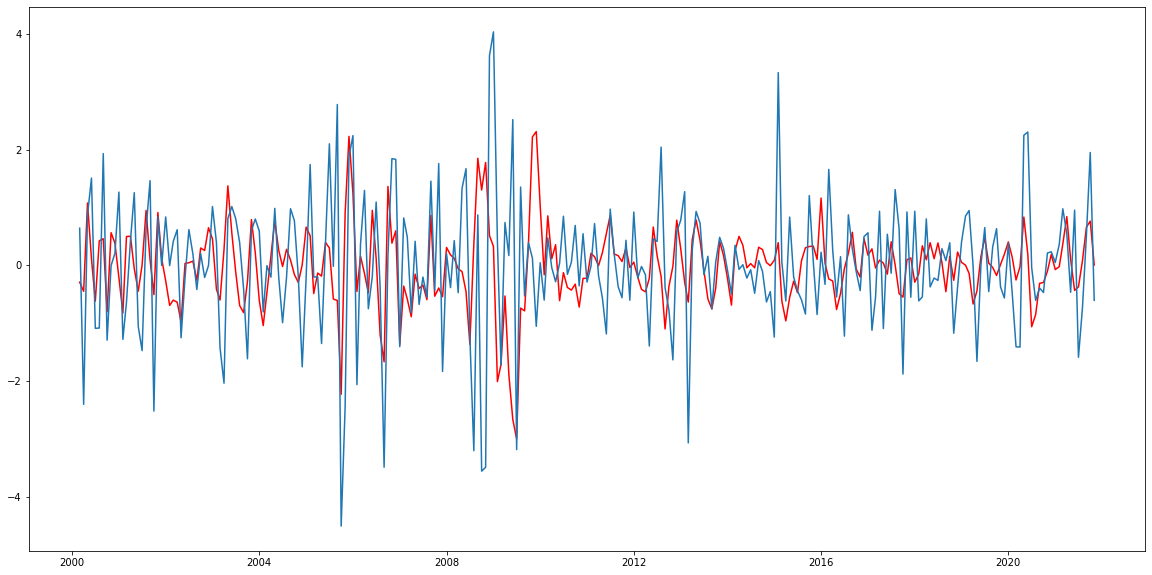

In [ ]:
plt.figure(figsize= (20, 10))
plt.plot(df["pred"], color = "red")
plt.plot(df["observed"])
plt.show()

The graph above shows how the AR model performs poorly in predicting inflation. The model had an MSE of 1.39, RMSE of 1.18 and an MAE of 0.83.